# Predicting mid-career salary based on education data

For this example we employ three datasets:

- One containing data sourced form the Wall Street Journal that analyzes salaries by college, region and academic major.
- A dataset compiled and shared through Kaggle, containing attributes related to many of the same colleges and universities as in the dataset above.
- Data from the College Scorecard published by the U.S. Department of Education.

Using this dataset we fit a multiclass logistic regression model that classifies students into likely salary brackets they will reach mid-career, depending on which school, major and other factors are applicable to each.

In [11]:
import sys
sys.path.insert(0, '../LIMEaid/controller')
sys.path.insert(0, '../LIMEaid/model')
sys.path.insert(0, '../LIMEaid/view')
import LIMEaid as la
import LIMEdisplay as ld
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import load_college_dataset as gcd
import fit_sklearn_models as fsm
from sklearn import preprocessing
from sklearn import tree

# Number of perturbed samples to be generated.
n = 100000
# Number of bins for the histograms of continous attributes.
num_bins = 25

The functions below merge and prepare the data, after uploading it, and leave it ready for us to fit the logistic regression model.

In [2]:
college = gcd.load_college_dataset()
features = list(college)[1:]
salary_class = np.array(college.iloc[:, 0])
college = np.array(college.iloc[:, 1:])

<_io.TextIOWrapper name='C:\\Users\\Castor18\\OneDrive\\MSDS_UW\\Data515_Spr19_Sw_Eng\\myproject\\LIMEaid\\LIMEaid\\model\\../data/Most-_Recent-_Cohorts-_Scorecard-_Elements.csv' mode='r' encoding='cp1252'>


Next we fit the logistic regression

In [3]:
clf = fsm.fit_multiclass_logistic_regression()

<_io.TextIOWrapper name='C:\\Users\\Castor18\\OneDrive\\MSDS_UW\\Data515_Spr19_Sw_Eng\\myproject\\LIMEaid\\LIMEaid\\model\\../data/Most-_Recent-_Cohorts-_Scorecard-_Elements.csv' mode='r' encoding='cp1252'>


## Interpreting the output of the Decision Tree using LIME.

We now take the dataset, attributes only, and form them we generate n random samples with similar distributions in the values of each attribute.

In [4]:
perturbed_samples = la.lime_sample(n, False, college[:, 0], num_bins)
for j in range(1, college.shape[1]):
    array = college[:, j]
    output = la.lime_sample(n, True, array, num_bins)
    perturbed_samples = np.vstack((perturbed_samples, output))
perturbed_samples = np.transpose(perturbed_samples)

Once random samples with the right distributions for each attribute have been generated, we provide them as input to the Logistic Regression model we fitted earlier, and obtain the classification for each.

In [5]:
class_perturb_samples = clf.predict(perturbed_samples)

We select a single instance from the dataset. This is the instance we will try to interpret using LIME.

In [6]:
college_norm = preprocessing.scale(college)
# Selecting the instance to interpret.
inst_num = np.round(np.random.uniform(0, college_norm.shape[0], 1))
inst_num = inst_num[0].astype(int)
# x is the selected instance, and x_class is the class assigned
# by the decision tree. 
x = college_norm[inst_num, :]
x_class = salary_class[inst_num]

## Calling LIME function to get intepretation.

In [7]:
# We now fit the LIME linear model to get the coefficients and
# intercept, as well as the weight of each random sample, 
# based on its L2 distance to the instance that is being
# interpreted.
lime_beta, lime_int, lime_weigh = la.lime_fit(x,
                                              x_class,
                                              perturbed_samples,
                                              class_perturb_samples)

## Intepreting the results

Below we present the results obtained from the LIME linear regression model, and identify those attributes that played a significant role in the classification that was assigned to each instance by the Logistic Regression classifier. 

In [8]:
# Print output of LIME results.
print("Instance to be interpreted:")
for j in range(0, len(lime_beta)):
    print("Feature: ", features[j], "\tvalue: ",
          college[inst_num, j], "\tnormalized value: ",
          college_norm[inst_num, j])
print("Classification: ", x_class)
print("\nSignificant coefficients from LIME adjusted"
      " linear model:")
significant_attributes = 0
for j in range(0, len(lime_beta)):
    if(lime_beta[j] != 0):
        significant_attributes = np.append(significant_attributes, j)
        print("Feature: ", features[j],
              "\tCoefficient: ", lime_beta[j])
significant_attributes = significant_attributes[1:]
print("Intercept: ", lime_int)

Instance to be interpreted:
Feature:  HCM2 	value:  0.0 	normalized value:  0.0
Feature:  SATVR25 	value:  560.0 	normalized value:  0.13540973317935553
Feature:  SATVR75 	value:  710.0 	normalized value:  0.827887130425389
Feature:  SATMT25 	value:  570.0 	normalized value:  0.08611237111313061
Feature:  SATMT75 	value:  700.0 	normalized value:  0.4618112360717146
Feature:  SATWR25 	value:  561.528735632184 	normalized value:  -1.725927392195095e-15
Feature:  SATWR75 	value:  664.6896551724138 	normalized value:  0.0
Feature:  ACTCM25 	value:  26.0 	normalized value:  0.44782049699812626
Feature:  ACTCM75 	value:  32.0 	normalized value:  0.9689035793685704
Feature:  ACTEN25 	value:  26.0 	normalized value:  0.6796439160741956
Feature:  ACTEN75 	value:  34.0 	normalized value:  1.464374242224048
Feature:  ACTMT25 	value:  25.0 	normalized value:  0.5864564202466008
Feature:  ACTMT75 	value:  31.0 	normalized value:  0.8244479681796466
Feature:  ACTWR25 	value:  7.408163265306122 	nor

If the number of significant attributes in the interpretation of a particular instance is equal to two, we plot the random samples and the instance that is being interpreted on a cathesian plane. In some cases, classes can be separated for the most part by looking at the two selected attributes. Note that those random samples that were classified differently from the instance we are interpreting are merged into a single out-of-class representation.

Finally, we plot the output of the fitted LIME Linear Regression model for each sample, against its class, as yielded by the Logistic Regression model and see that, in most cases, the classes can be differentiated using this model only.

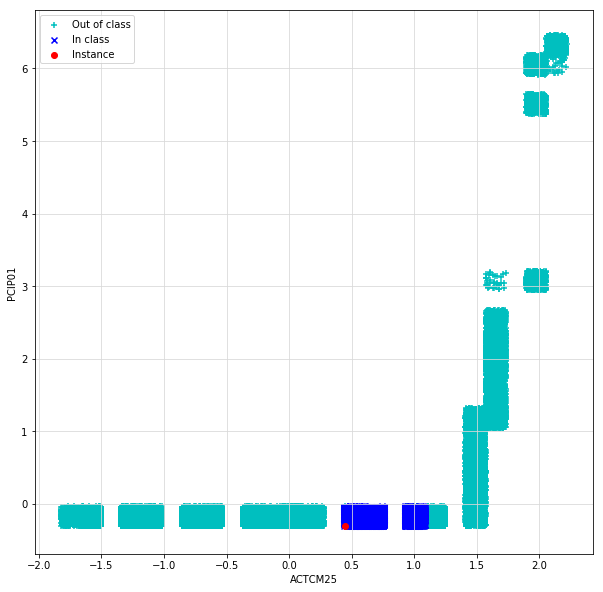

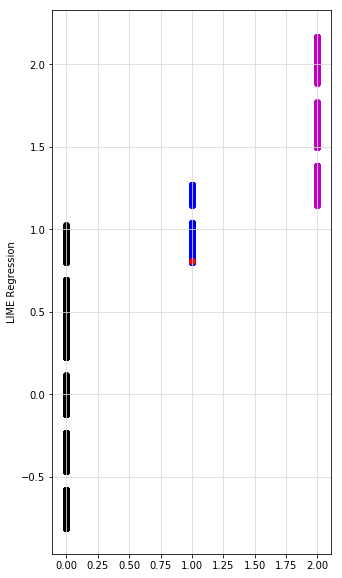

In [9]:
full_data = np.column_stack((perturbed_samples, class_perturb_samples))
ld.lime_display(full_data, lime_beta, lime_int, x, x_class, features)